In [1]:
# Imports
import sys
sys.path.append('../')
sys.path.append('../../')
from imports import *

print(sys.path)

['x:\\git\\LRZ\\masters-thesis\\prediction\\mlp', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310', '', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin', '../']


IoT Server at 100.113.141.113 initialized
Current directory before change: x:\git\LRZ\masters-thesis\prediction\mlp
Current directory after change: x:\git\LRZ\masters-thesis\prediction\mlp
Response for 'INV2' saved successfully!
Response for 'TEMP' saved successfully!
Response for 'HUM' saved successfully!


<AxesSubplot: xlabel='Date'>

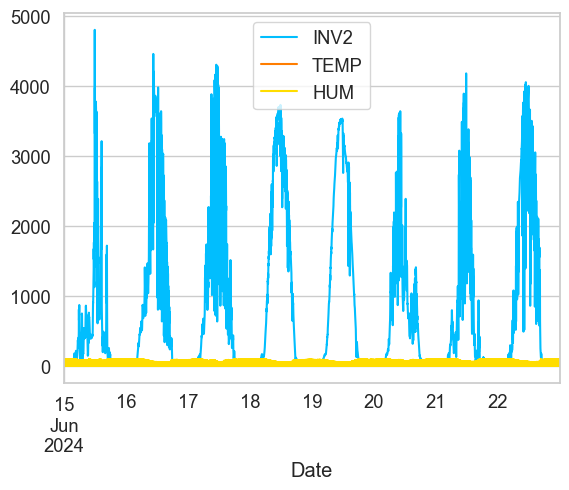

In [47]:
# Get Data over 7 days

ip = "100.113.141.113"
devices = ["INV2", "TEMP", "HUM"] # First device defines the value to be forecasted
time_abs_start = "2024-06-15T00:00:00Z"
time_abs_end   = "2024-06-23T00:00:00Z"
# time_abs_start = "2024-08-25T00:00:00Z"
# time_abs_end   = "2024-08-26T00:00:00Z"

time_range = "None"
res = "1m"

# Day before --> basis for prediction
iot_server = IotGrabber(
                          ip=ip,
                          devices=devices,
                          time_abs_start=time_abs_start,
                          time_abs_end=time_abs_end,
                          range=time_range,
                          res=res,
                          delimiter=";",
                          cwd=os.getcwd()
                          )

# print(iot_server)
df_iot_server = iot_server.get_df()


df_iot_server.plot()


In [107]:
from collections import OrderedDict
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


In [114]:
class MLP(pl.LightningModule):
    def __init__(self, hidden_params=None, configs=None):
        super().__init__()
        self.configs = configs

        layers = OrderedDict()
        for idx, params in enumerate(hidden_params):
            linear_name = f'linear_{idx+1}'
            layers[linear_name] = nn.Linear(*params, bias=True)
            sigmoid_name = f'sigmoid_{idx+1}'
            layers[sigmoid_name] = nn.Sigmoid()

        self.layers = nn.Sequential(layers)

        # Get the last dim of last hidden layer
        last_dim = hidden_params[-1][-1]
        self.output = nn.Linear(last_dim, 1, bias=True)

        # Initialize weights
        for m in self.modules():
            if type(m) == nn.Linear:
                torch.nn.init.normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(1.0)

    def forward(self, x):
        h = self.layers(x)
        return self.output(h)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(), lr=self.configs.learning_rate, momentum=self.configs.momentum)
        return optimizer

    def get_regularization(self, regularizer='L2', strength=0.1):
        reg = torch.Tensor([0])
        for params in self.parameters():
            if regularizer == 'L1':
                reg += torch.norm(params, 1)
            elif regularizer == 'L2':
                reg += torch.norm(params, 2)
        return reg * strength

    def training_step(self, train_batch, train_idx):
        inputs, labels = train_batch
        if self.configs.sigma:  # Add noise to the data
            inputs += np.random.normal(0, self.configs.sigma)
        predictions = self.forward(inputs)
        loss = F.mse_loss(predictions, labels)
        if self.configs.regularizer:
            loss = loss * self.get_regularization(self.configs.regularizer, getattr(self.configs, 'lambda'))
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, val_idx):
        inputs, labels = val_batch
        predictions = self.forward(inputs)
        loss = F.mse_loss(predictions, labels)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def test_step(self, test_batch, test_idx):
        inputs, labels = test_batch
        predictions = self.forward(inputs)
        loss = F.mse_loss(predictions, labels)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss

    def predict(self, inputs):
        predictions = self.forward(inputs)
        return predictions.detach().numpy()

    def get_weights(self, to_numpy=True):
        weights = torch.Tensor()
        for name, parameter in self.named_parameters():
            if 'weight' in name:
                weights = torch.cat((weights, parameter.view(-1)), 0)
        if to_numpy:
            weights = weights.detach().numpy()
        return weights


if __name__ == '__main__':
    model = MLP(hidden_params=[(3, 4), (4, 1)])
    init_weights = model.get_weights()
    # assert len(init_weights) == 3 * 4 + 4 * 3 + 1

In [113]:
len(init_weights)

17

In [77]:
# Remove Date from index to column
df_iot_server_without_index = df_iot_server.reset_index()
df = df_iot_server_without_index.copy(deep=True)

# # Sort df new
# col_date = df.Date.to_list()
# col_inv  = df.INV2.to_list()
df.drop("Date", axis=1, inplace=True)
# df["Date"] = col_date

# df.head()
# # Convert Date to seconds
# timestamps = df["Date"].to_list()
# timestamps_sec = []
# # t = t.total_seconds()
# for timestamp in timestamps:
#     # print(f"Type: {type(timestamp)}, Value: {timestamp}")
#     timestamps_sec.append(timestamp.timestamp())

# df["Date"] = timestamps_sec
df.head()

,INV2,TEMP,HUM
0,0.0,0.00,0.0
1,0.0,0.00,0.0
2,0.0,0.00,0.0
3,0.0,12.58,90.0
4,0.0,0.00,0.0


In [94]:
X = df.drop('INV2', axis=1).values
y = df['INV2'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class factbook_data:
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            if scale_data:
                X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class MLP(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)
    



In [95]:
if __name__=='__main__':
    torch.manual_seed(42)
    X,y = X, y

In [96]:

dataset = factbook_data(X, y, scale_data=False)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)


In [97]:
n = len(df.columns) - 1
mlp = MLP(n)

loss_function = nn.L1Loss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=1e-4)

In [103]:

for epoch in range(0,20):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        mlp.train()

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        if i%10 == 0:
            print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/500))
            current_loss = 0.0

    print(f'Epoch {epoch+1} finished')

print("Training has completed")

Starting Epoch 1
Loss after mini-batch     1: 1.754
Loss after mini-batch    11: 18.167
Loss after mini-batch    21: 17.601
Loss after mini-batch    31: 16.668
Loss after mini-batch    41: 14.624
Loss after mini-batch    51: 15.293
Loss after mini-batch    61: 17.344
Loss after mini-batch    71: 13.983
Loss after mini-batch    81: 18.712
Loss after mini-batch    91: 15.717
Loss after mini-batch   101: 16.725
Loss after mini-batch   111: 18.809
Loss after mini-batch   121: 21.788
Loss after mini-batch   131: 14.620
Loss after mini-batch   141: 12.752
Loss after mini-batch   151: 18.812
Loss after mini-batch   161: 18.250
Loss after mini-batch   171: 18.554
Loss after mini-batch   181: 18.286
Loss after mini-batch   191: 15.180
Loss after mini-batch   201: 18.562
Loss after mini-batch   211: 18.477
Loss after mini-batch   221: 15.828
Loss after mini-batch   231: 13.430
Loss after mini-batch   241: 13.961
Loss after mini-batch   251: 15.925
Loss after mini-batch   261: 13.873
Loss after m

In [104]:
test_data = torch.from_numpy(X_test).float()
test_targets = torch.from_numpy(y_test).float()
mlp.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [105]:
with torch.no_grad():
    outputs = mlp(test_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
test_targets = np.array(test_targets)

mse = root_mean_squared_error(test_targets, predicted_labels)
r2 = r2_score(test_targets, predicted_labels)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 1421.4996956745424
R2 Score: -0.5131814231151062


In [106]:
print(predicted_labels)

[10.15219307  0.3197358   8.68010235 ...  0.3197358   0.3197358
  0.3197358 ]


RMSE: 72.39499959543483
                    Date  INV2  Sine  dINV2
0    2024-08-24 00:00:00   0.0   0.0    0.0
1    2024-08-24 00:01:00   0.0   0.0    0.0
2    2024-08-24 00:02:00   0.0   0.0    0.0
3    2024-08-24 00:03:00   0.0   0.0    0.0
4    2024-08-24 00:04:00   0.0   0.0    0.0
...                  ...   ...   ...    ...
1435 2024-08-24 23:55:00   0.0   0.0    0.0
1436 2024-08-24 23:56:00   0.0   0.0    0.0
1437 2024-08-24 23:57:00   0.0   0.0    0.0
1438 2024-08-24 23:58:00   0.0   0.0    0.0
1439 2024-08-24 23:59:00   0.0   0.0    0.0

[1440 rows x 4 columns]


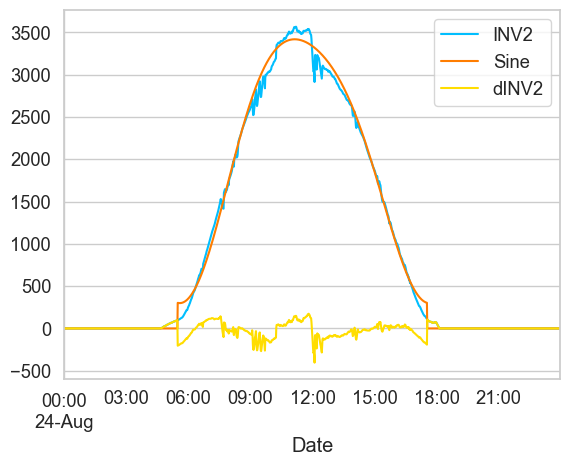

In [4]:
# Calculate absolute deviation between the real values and the sine prediction from the day before
dPredicitionWithSine = df.INV2.values - INV2_modeled

# Sum everything in a pandas df
df_computed = pd.DataFrame()
df_computed.insert(0, "Date", df.index.values)
df_computed.insert(1, "INV2", df.INV2.values)
df_computed.insert(2, "Sine", INV2_modeled)
df_computed.insert(3, "dINV2", dPredicitionWithSine)
df_computed.set_index("Date")
df_computed.to_csv("sine-prediction-compareSameDay.csv", sep=";")

# Calc RMSE value
rmse_sine = calc_rmse(df_computed.INV2, df_computed.Sine)

# Plot
df_computed.plot(x=0)
print(f"RMSE: {rmse_sine}")
with open("rmse-calc.txt", "w+") as f:
    f.write(f"{rmse_sine}")
print(df_computed)

In [9]:
max(df.INV2.values)- max(df.INV3.values)

-144.9560546875